Kornpob Bhirombhakdi, kbhirombhakdi@stsci.edu

# Story
We would like to make a drzblot image setting for X01, 201911, G102.

# Previously
02_X01_G102_extraction.ipynb was performing G102 extraction of X01 at epoch 201911. We used drzblot image calibrated for GRB 190829A. However, we realized that this was incorrect, and we need a new drzblot image calibrated for X01.

# Task
- For each flt:
 - make flatfield image
 - make flatfielded flt
- drizzle
- blot back

# Resource
- GRB190829A/01_making_drzblot/01_GRB190829A_201911_G102.ipynb will serve as the template.


In [38]:
from hstgrism.container import Container
from hstgrism.computetracenwavelength import ComputeTraceNWavelength
from hstgrism.computexyref import ComputeXYREF
from hstgrism.wfc3irg102 import WFC3IRG102
from hstgrism.wfc3irg141 import WFC3IRG141
from hstgrism.cutout2d import Cutout2D
from hstgrism.flatfield import FlatField
from hstgrism.show_overview import show_overview
import pandas as pd
import os

def generate_flatfield_flt(saveprefix,savefolder,plotformat,overwrite,
                           xyd,confile,beam,gfile,dfile,
                           flatfile,
                           params_overview,
                           filterobs
                          ):
    """
    Use hstgrism to make flatfielded grism flt.
    """
    ##########
    # Make Container
    ##########
    container_params = {'saveprefix':saveprefix,
                        'savefolder':savefolder,
                        'plotformat':plotformat,
                        'overwrite':overwrite
                       }
    containerobj = Container(**container_params)
    ##########
    # Compute xyref
    ##########
    xyref_params = {'xyd':xyd,
                    'xydiff':'default',
                    'xyoff':'default',
                    'confile':confile,
                    'beam':beam,
                    'gfile':gfile,
                    'dfile':dfile,
                    'container':containerobj
                   }
    xyrefobj = ComputeXYREF(**xyref_params)
    xyrefobj.compute()
    xyrefobj.save()
    ##########
    # Map trace and wavelength
    ##########
    xyref = xyrefobj.data['xyref']
    grism_params = {'confile':confile,
                    'beam':beam,
                    'xyref':xyref,
                    'container':containerobj
                   }
    if filterobs == 'G102':
        grismobj = WFC3IRG102(**grism_params)
    elif filterobs == 'G141':
        grismobj = WFC3IRG141(**grism_params)
    else:
        raise ValueError('filterobs = {0} is not supported.'.format(filterobs))
    grismobj.compute()
    grismobj.save()
    ##########
    # show_overview
    ##########
    show_overview(gfile,dfile,xyd,xyref,grismobj.output['xh'],grismobj.output['yh'],grismobj.output['ww'],
                  objname=containerobj.data['saveprefix'],
                  save=True,
                  container=containerobj,
                  params=params_overview
                 )    
    ##########
    # Make cutout
    ##########
    tfile = './{0}/{1}_trace.csv'.format(containerobj.data['savefolder'],containerobj.data['saveprefix'])
    tdata = pd.read_csv(tfile)
    xg = tdata.xh + tdata.xyref[0]
    yg = tdata.yh + tdata.xyref[1]
    halfdy = 20
    tbox = {'xg':xg,'yg':yg,'halfdyup':halfdy,'halfdylow':halfdy}
    bbox={'padxleft': 15, 'padxright': 15, 'padyup': 15, 'padylow': 15}
    image = fits.open(gfile[0])[gfile[1]].data
    do_mask = True
    cutoutobj = Cutout2D(tbox,bbox,image,containerobj)
    cutoutobj.compute(do_mask)
    cutoutobj.save()
    ##########
    # Make flatfield
    ##########
    tfile = './{0}/{1}_trace.csv'.format(containerobj.data['savefolder'],containerobj.data['saveprefix'])
    tdata = pd.read_csv(tfile)
    bbcorner = './{0}/{1}_bbcorner.csv'.format(containerobj.data['savefolder'],containerobj.data['saveprefix'])
    bbdata = pd.read_csv(bbcorner)
    flatobj = FlatField(container=containerobj,flatfile=flatfile,xyref=tdata.xyref,dldp=tdata.dldp)
    flatobj.compute()
    flatobj.save(do_cutout=False)
    ##########
    # Make flatfielded flt
    ##########
    string = './{0}/{1}'.format(containerobj.data['savefolder'],gfile[0].split('/')[-1])
    os.system('cp {0} {1}'.format(gfile[0],string))
    gfile_new = (string,1)
    ffile = ('./{0}/{1}_fullflat.fits'.format(containerobj.data['savefolder'],containerobj.data['saveprefix']),1)
    tmp = fits.open(gfile_new[0])
    tmpdata = tmp[gfile_new[1]].data.copy()
    flatdata = fits.open(ffile[0])[ffile[1]].data.copy()
    m = np.isfinite(flatdata)
    tmpdata[m] = tmpdata[m] / flatdata[m]
    tmp[gfile_new[1]].data = tmpdata.copy()
    tmp.writeto(gfile_new[0],overwrite=True)
    print('Update flatfielded {0}'.format(gfile_new[0]))
    

In [44]:
from hstphot.read_ds9region import read_ds9region
from drizzlepac.astrodrizzle import AstroDrizzle
from drizzlepac import ablot
from astropy.io import fits
import numpy as np
import glob,copy


In [41]:
# Set files
fpath = '/Users/kbhirombhakdi/_work/_data/15510/mastDownload/HST/*k3z*/*flt.fits'
tmp = np.array(glob.glob(fpath))
tlist = tmp
tlist = [tmp[5],tmp[0],tmp[2],tmp[3],tmp[4],tmp[6],tmp[7]]
for ii,i in enumerate(tlist):
    h = fits.open(i)[0].header
    hs = fits.open(i)[1].header
    string = '{0} {1} {2} {3} {4} {5} {6} {7} {8}'.format(ii,h['ROOTNAME'],h['FILTER'],h['EXPSTART'],h['SUBARRAY'],
                       h['POSTARG1'],h['POSTARG2'],hs['IDCSCALE'],h['DATE-OBS']
                      )
    print(string)
flist = copy.deepcopy(tlist)


0 idwbk3z0q F105W 58816.81739521 False -28.613661 -32.611141 0.1282500028610229 2019-11-29
1 idwbk3z1q G102 58816.82177003 False -28.613661 -32.611141 0.1282500028610229 2019-11-29
2 idwbk3z7q G102 58816.88845966 False -27.596661 -32.248138 0.1282500028610229 2019-11-29
3 idwbk3z4q G102 58816.83943225 False -25.90766 -30.19314 0.1282500028610229 2019-11-29
4 idwbk3zaq G102 58816.90612188 False -24.890659 -29.827141 0.1282500028610229 2019-11-29
5 idwbk3z9q G102 58816.89729077 False -26.24366 -31.039141 0.1282500028610229 2019-11-29
6 idwbk3z3q G102 58816.83060114 False -27.26066 -31.40214 0.1282500028610229 2019-11-29


In [46]:
sourcename = 'X01'
confile = '/Users/kbhirombhakdi/_work/_calib_files/WFC3.IR.G102.cal.V4.32/G102.F105W.V4.32.conf'
flatfile = '/Users/kbhirombhakdi/_work/_calib_files/WFC3.IR.G102.cal.V4.32/WFC3.IR.G102.flat.2.fits'
dateobs = '201911'
filterobs = 'G102'
identifier = '{0}_{1}_{2}'.format(sourcename,dateobs,filterobs)
ds9file = '/Users/kbhirombhakdi/_work/_data/15510/mastDownload/HST/idwbk3z0q/idwbk3z0q.reg'


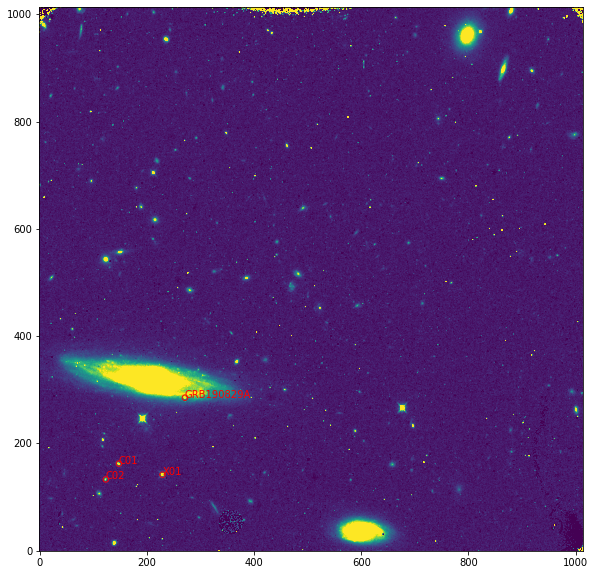

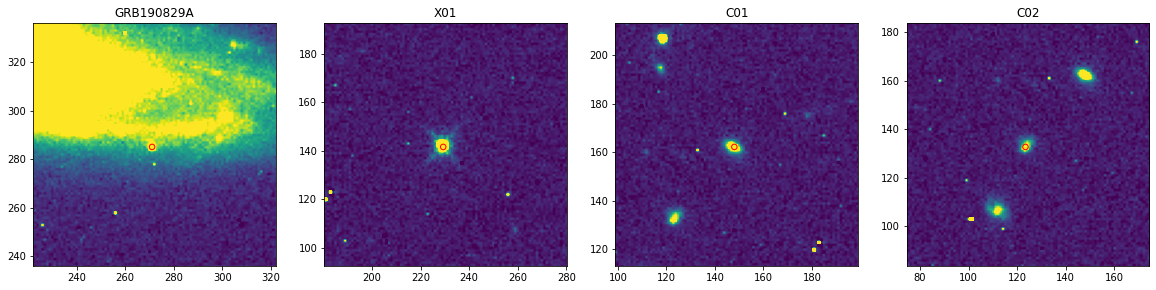

In [47]:
tmp = ds9file
sourcelist = read_ds9region(tmp)
tmpdata = fits.open(flist[0])[1].data
plt.figure(figsize=(10,10))
m = np.isfinite(tmpdata)
vmin,vmax = np.percentile(tmpdata[m],5.),np.percentile(tmpdata[m],99.)
plt.imshow(tmpdata,origin='lower',cmap='viridis',vmin=vmin,vmax=vmax)

for i in sourcelist:
    x,y = sourcelist[i]
    plt.scatter(x-1,y-1,s=30,edgecolor='red',facecolor='None',label=i)
    plt.annotate(i,(x-1,y-1),fontsize=10,color='red')
    
n = len(sourcelist)
dx,dy = 50,50
fig = plt.figure(figsize=(5*n,5))
for i,ii in enumerate(sourcelist):
    x,y = sourcelist[ii]
    ax = fig.add_subplot(1,n,i+1)
    ax.imshow(tmpdata,origin='lower',cmap='viridis',vmin=vmin,vmax=vmax)
    ax.scatter(x-1,y-1,s=30,edgecolor='red',facecolor='None',label=i)
    ax.set_xlim(x-dx,x+dx)
    ax.set_ylim(y-dy,y+dy)
    ax.set_title(ii,fontsize=12)
    

Save ./idwbk3z1q_X01_201911_G102/idwbk3z1q_X01_201911_G102_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./idwbk3z1q_X01_201911_G102/idwbk3z1q_X01_201911_G102_trace.csv
Save ./idwbk3z1q_X01_201911_G102/idwbk3z1q_X01_201911_G102_overview.pdf

Save ./idwbk3z1q_X01_201911_G102/idwbk3z1q_X01_201911_G102_tbox.csv
Save ./idwbk3z1q_X01_201911_G102/idwbk3z1q_X01_201911_G102_bbox.csv
Save ./idwbk3z1q_X01_201911_G102/idwbk3z1q_X01_201911_G102_bbcorner.csv
Save ./idwbk3z1q_X01_201911_G102/idwbk3z1q_X01_201911_G102_cutout.fits
Save ./idwbk3z1q_X01_201911_G102/idwbk3z1q_X01_201911_G102_mask.fits
Save ./idwbk3z1q_X01_201911_G102/idwbk3z1q_X01_201911_G102_fullflat.fits
Update flatfielded ./idwbk3z1q_X01_201911_G102/idwbk3z1q_flt.fits
Save ./idwbk3z7q_X01_201911_G102/idwbk3z7q_X01_201911_G102_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale =

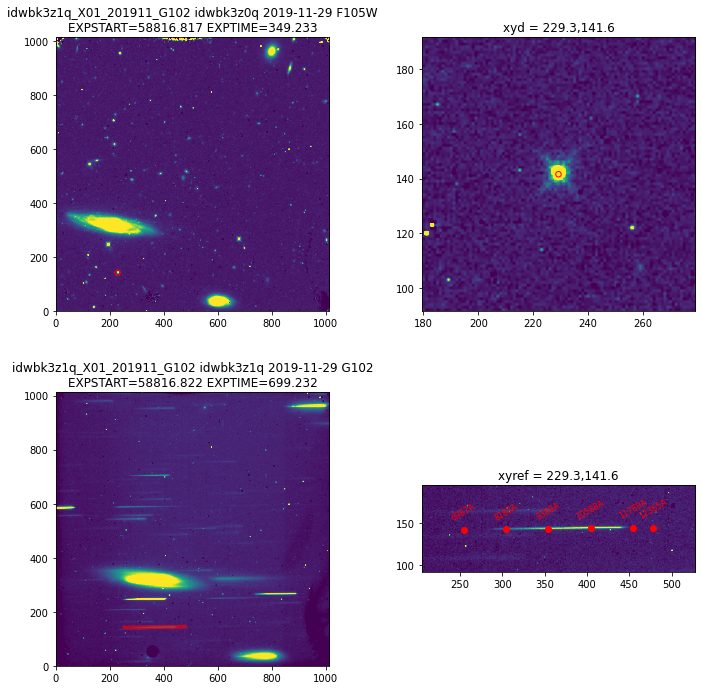

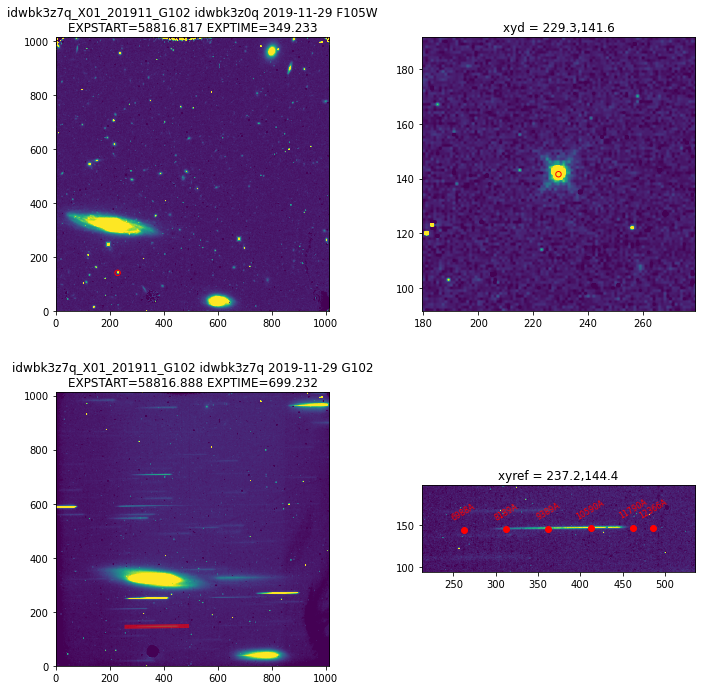

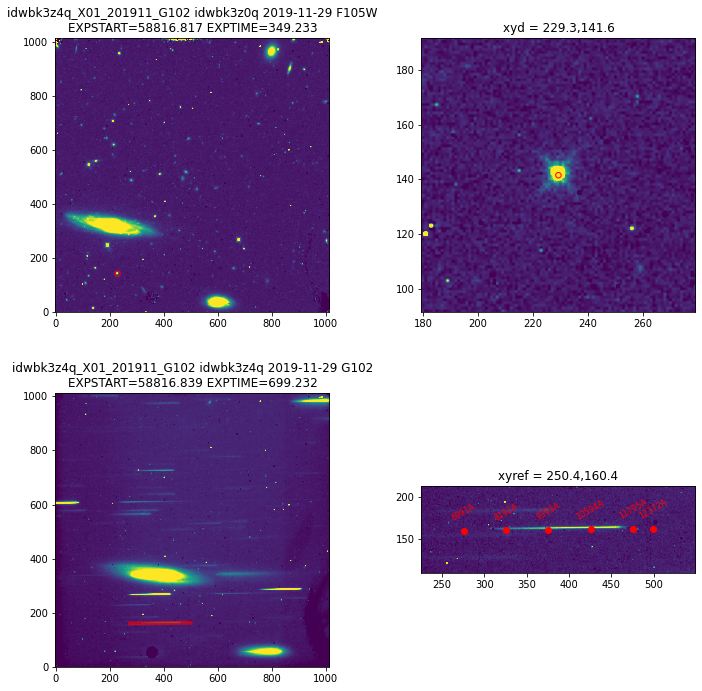

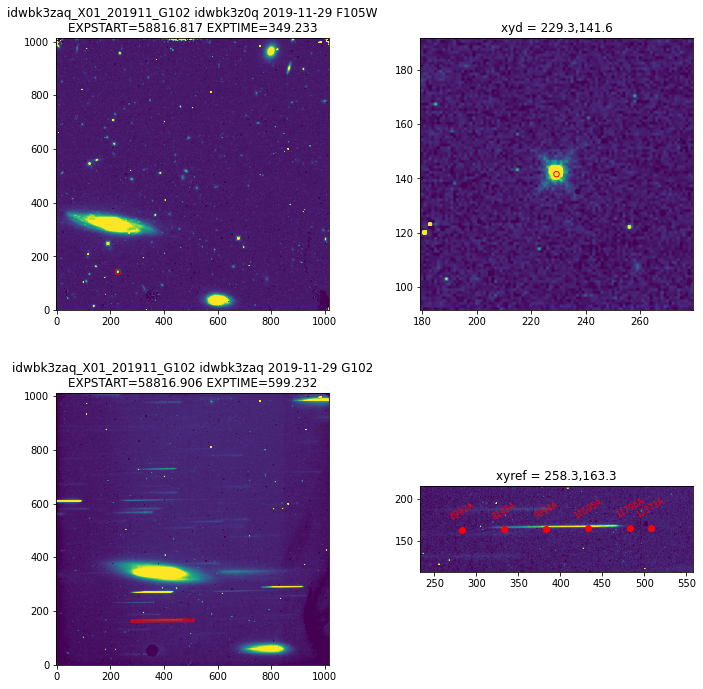

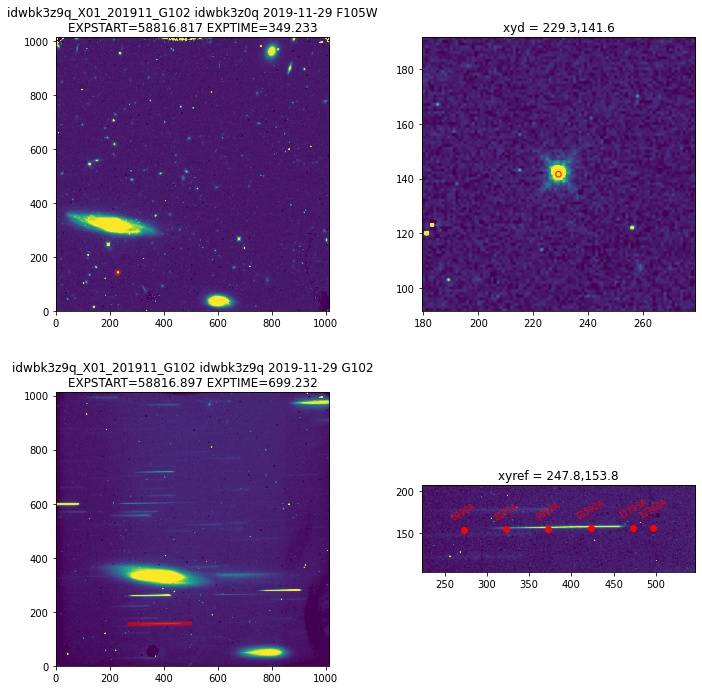

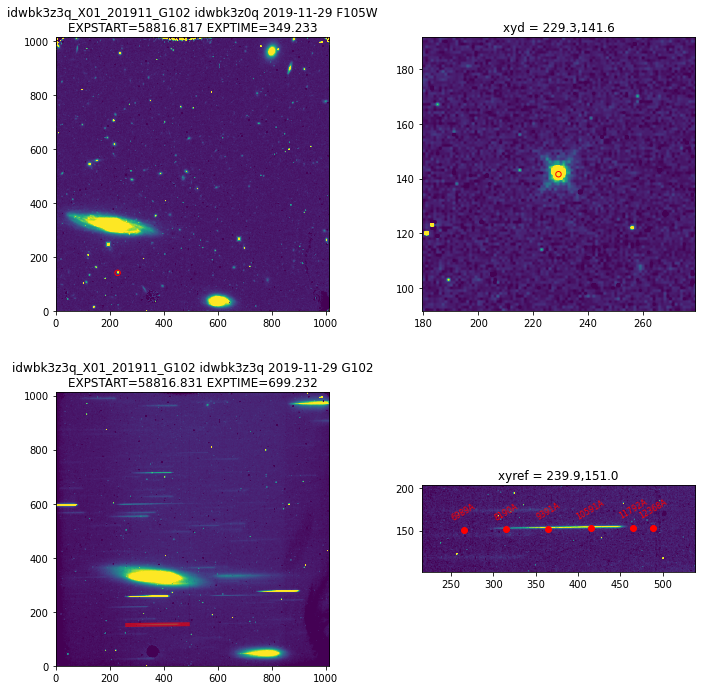

In [48]:
for i,ii in enumerate(flist):
    if i == 0:
        continue
    for j,jj in enumerate(sourcelist):
        if jj != sourcename:
            continue
        dfile = (flist[0],1)
        gfile = (flist[i],1)
        rootname = fits.open(gfile[0])[0].header['ROOTNAME']
        sourcename = jj
        saveprefix = '{0}_{1}'.format(rootname,identifier)
        savefolder = saveprefix
        plotformat = 'pdf'
        overwrite = False
        x,y = sourcelist[sourcename]
        xyd = (x-1,y-1)
        beam = 'A'
        params_overview = {'figsize': (10, 10), 
                           '221': {'minmax': (5.0, 99.0), 'cmap': 'viridis', 's': 30, 'facecolor': 'None', 'edgecolor': 'red', 'fontsize': 12, 'title': 'default'}, 
                           '222': {'minmax': (5.0, 99.0), 'cmap': 'viridis', 's': 30, 'facecolor': 'None', 'edgecolor': 'red', 'padxy': (50, 50), 'fontsize': 12, 'title': 'default'}, 
                           '223': {'minmax': (5.0, 99.0), 'cmap': 'viridis', 's': 30, 'facecolor': 'None', 'edgecolor': 'red', 'color': 'red', 'ls': '-', 'lw': 4, 'alpha': 0.6, 'fontsize': 12, 'title': 'default'}, 
                           '224': {'minmax': (5.0, 99.0), 'cmap': 'viridis', 's': 30, 'facecolor': 'None', 'edgecolor': 'red', 'color': 'red', 'ls': '-', 'lw': 0, 'alpha': 0.6, 'padxy': (50, 50), 'tickperx': 50, 'annotate_marker': 'ro', 'annotate_color': 'red', 'annotate_fontsize': 8, 'annotate_rotation': 30.0, 'fontsize': 12, 'title': 'default'}}
        generate_flatfield_flt(saveprefix,savefolder,plotformat,overwrite,
                                   xyd,confile,beam,gfile,dfile,
                                   flatfile,
                               params_overview,filterobs
                                  )
        

In [49]:
# make drzlist
drzlist = []
for ii,i in enumerate(flist):
    if ii==0:
        continue
    tmp = i.split('/')[-1]
    tmpp = tmp.split('_')[0]
    string = './{0}_{1}/{2}'.format(tmpp,identifier,tmp)
    drzlist.append(string)
drzlist


['./idwbk3z1q_X01_201911_G102/idwbk3z1q_flt.fits',
 './idwbk3z7q_X01_201911_G102/idwbk3z7q_flt.fits',
 './idwbk3z4q_X01_201911_G102/idwbk3z4q_flt.fits',
 './idwbk3zaq_X01_201911_G102/idwbk3zaq_flt.fits',
 './idwbk3z9q_X01_201911_G102/idwbk3z9q_flt.fits',
 './idwbk3z3q_X01_201911_G102/idwbk3z3q_flt.fits']

In [50]:
# drizzle
params_drz = {'build':True,
          'restore':False,
          'overwrite':False,
          'clean':True,
          # Step 1 Statis Mask
          'static':False,
          # Step 2 Sky Sub
          'skysub':True,
          'skymethod':'localmin',
          'skystat':'median',
          # Step 3 Driz Sep
          'driz_separate':True,
          'driz_sep_kernel':'turbo',
          'driz_sep_pixfrac':1., # Set this high for CR
#           'driz_sep_scale':0.05, # Smaller than native size, better for CR
          # Step 4 Median
          'median':True,
          'combine_type':'median',
          'combine_nhigh':1, # Reject highest values before computing median, good for CR
          # Step 5 Blot
          'blot':True,
          'blot_interp':'poly5',
          'blot_addsky':True,
          # Step 6 CR
          'driz_cr':True,
          'driz_cr_corr':True,
          'driz_cr_ctegrow':0,
          # Step 7 Final Combine
          'driz_combine':True,
              'final_refimage':drzlist[0]
         }
AstroDrizzle(input=drzlist,
             output='{0}'.format(identifier),
             **params_drz
            )


Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 3.1.6 (2020-02-19 16:16:30 -0500) started at: 15:50:28.82 (21/08/2020)

==== Processing Step  Initialization  started at  15:50:28.830 (21/08/2020)

Creating OUTPUT WCS from ./idwbk3z1q_X01_201911_G102/idwbk3z1q_flt.fits[1]
WCS Keywords

CD_11  CD_12: -1.8535123636411e-06 -3.356517570308e-05
CD_21  CD_22: -3.7573078339169e-05 1.5432356282565e-06
CRVAL    : 44.535928876384 -8.9662964459753
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13542756566728567
ORIENTAT : -87.36754952931922
********************************************************************************
*
*  Estimated memory usage:  up to 117 Mb.
*  Output image size:       1014 X 1014 pixels. 
*  Output image file:       ~ 11 Mb. 
*  Cores available:         6
*
********************************************************************************
==== Processing Step Initialization finished at 15:50:29.809 (21/08/2020)
==== Processing Step  Static Mask  starte

reference sky value for image '/Users/kbhirombhakdi/_work/Sidekicks/20200821/idwbk3zaq_X01_201911_G102/idwbk3zaq_flt.fits' is 358.09663917022726
reference sky value for image '/Users/kbhirombhakdi/_work/Sidekicks/20200821/idwbk3z9q_X01_201911_G102/idwbk3z9q_flt.fits' is 425.9924760563828
reference sky value for image '/Users/kbhirombhakdi/_work/Sidekicks/20200821/idwbk3z3q_X01_201911_G102/idwbk3z3q_flt.fits' is 423.4169730337438
Saving output median image to: 'X01_201911_G102_med.fits'
==== Processing Step Create Median finished at 15:50:33.011 (21/08/2020)
==== Processing Step  Blot  started at  15:50:33.013 (21/08/2020)

    Blot: creating blotted image:  /Users/kbhirombhakdi/_work/Sidekicks/20200821/idwbk3z1q_X01_201911_G102/idwbk3z1q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: /Users/kbhirombhakdi/_work/Sidekicks/20200821/idwbk3z1q_X01_201911_G102/idwbk3z1q_sci1_blt.fits
Writing out image to disk: /Users/kbhirombhakdi/_work/Sid

In [51]:
# setup for drzblot
drzfile = glob.glob('./{0}_drz.fits'.format(identifier))[0]
reffile = drzlist[0]
skyval = fits.open(reffile)[1].header['MDRIZSKY']
rootname = reffile.split('/')[-1].split('_')[0]
outdata = './drzblot_{0}/{1}_drzblot_sci.fits'.format(identifier,rootname)
drzfile,reffile,skyval,outdata


('./X01_201911_G102_drz.fits',
 './idwbk3z1q_X01_201911_G102/idwbk3z1q_flt.fits',
 0.6108115911483765,
 './drzblot_X01_201911_G102/idwbk3z1q_drzblot_sci.fits')

In [52]:
# facilitate creating folder
saveprefix = rootname
savefolder = 'drzblot_{0}'.format(identifier)
plotformat = 'pdf'
overwrite = False
containter_drzblot = Container(saveprefix,savefolder,plotformat,overwrite)
# blot
ablot.blot('{0}[1]'.format(drzfile),'{0}[1]'.format(reffile),addsky=False,skyval=skyval,
           outdata=outdata,in_units='counts',out_units='cps')
# replace back
os.system('cp {0} ./{1}/'.format(flist[1],savefolder))
string = './{0}/{1}'.format(savefolder,flist[1].split('/')[-1])
tmp = fits.open(string)
tmpp = fits.open(outdata)
tmp[1].data = tmpp[1].data.copy()
tmp.writeto(string,overwrite=True)


Using coordinate transformation defined by user...
Added 0.6108115911483765 counts back in to blotted image as sky.
Created output image: ./drzblot_X01_201911_G102/idwbk3z1q_drzblot_sci.fits


# Summary
The drzblot file for X01 201911 G102 locates at 20200821/drzblot_X01_201911_G102/idwbk3z1q_flt.fits.
